# Assignment 4 16018942

### Table of Contents
1. [Finite Stencil Method](#finitemethods)
    1. [Explicit Implementation](#finiteexplicit)
    2. [Implicit Implementation](#finiteimplicit)
2. [Spectral Differentiation Method](#spectralmethods)
    1. [Explicit Implementation](#spectralexplicit)
    2. [Implicit Implementation](#spectralimplicit)
3. [Investigation of Spectal Differentiation](#investigation)
###### N.B Notebook runs in $\approx 115s$ on computer used for development (Ubuntu 18.04.3 LTS, Intel® Core™ i7-6600U CPU @ 2.60GHz × 4) and formatting has been checked with autopep8 (https://pypi.org/project/autopep8/)

### N.B. 3D plots may disappear or kill kernel if you 'Run All', just re run their code cell to interact with them.

### Introduction
    
The problem we are attempting to numerically solve is,
$$ u_t = \Delta u $$
with boundary conditions $u=5$ on one side and $u=0$ on all other sides. This models heating a region of space at $temperature=0$ with a hot plate at a boundary at $temperature=5$, i.e. a heat diffusion problem.

We are specifically solving this problem in time up to the point that the middle of the plate reaches $u=1$. The value of time at this point is the value we are attempting to compute with our numerical methods. 

We define the problem as running through time from $T = 0 \rightarrow T=1$. This means at some value of $T^*=?$ the middle of the plate reaches $u=1$, this is the target value. 

First I'll briefly discuss some theory behind the methods employed and then carry them out.



In [1]:
import pyopencl as cl
import scipy as sp
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import aslinearoperator
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import cgs
from scipy.sparse.linalg import spilu
import numexpr as ne
import matplotlib.pyplot as plt
import random
from random import randint
import numba as nb
from numba import njit
from numba import jit
from numba import prange
from numba import types
from multiprocessing import Pool
from multiprocessing import Process
from functools import partial
import time
#from time import time
%matplotlib inline
PI = np.pi
import sys
import os

#Modify Numba Compilation Output
os.environ["NUMBA_DISABLE_PERFORMANCE_WARNINGS"] = '1'
#plt.style.use('dark_background')

We know from other historical work that the expected solution is, $$0.424011387033$$ so we can use this as a benchmark for comparing our result.

N.B. Nomenclature: Accuracy is often used as a term throughout the notebook, to clarify its meaning I mean the delta from the target value as defined by this function.

In [2]:
@njit(nb.double(nb.double,nb.double))
def target_dif(variable,option):
    '''Function to test results against target.
    Outputs decimal accuraccy or accuracy depending
    on option'''
    
    if option == 1:
    
        a = np.abs(np.floor(np.log10(np.abs(0.424011387033-variable))))

    elif option == 0:
        a = np.abs(0.424011387033-variable)
    return a

We define a timer class for creating a metric for the different numerical methods. Although the core purpose of this task is computing the $T^*$ value we still want to consider the performance optimisation of different methods.

In [3]:
class Timer: 
    """Calculates the time it takes to run a piece of code.

    """
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


## Explicit vs Implicit; Explanation

(some background reading from **H. P. Langtangen and S. Linge: Finite Difference Computing with PDEs - A Modern Software Approach**)

For solving a problem with a time dependancy there are generally two approaches that can be implemented to include time into an already complete spatial method. These are known as explicit and implicit methods, sometimes described as Forwards Euler and Backwards Euler.

Quoting from literature:

"Discretization methods that lead to a coupled system of equations for the unknown function at a new time level are said to be implicit methods. The counterpart, explicit methods, refers to discretization methods where there is a simple explicit formula for the values of the unknown function at each of the spatial mesh points at the new time level. From an implementational point of view, implicit methods are more comprehensive to code since they require the solution of coupled equations, i.e., a matrix system, at each time level."

#### Explicit

Involves solving an equation with one unknown, the point in the system at the next time frame.

#### Implicit

Involves solving an equation with 5 unknowns, the point in the system and 4 surrounding points at the next time frame.


This difference is important and although both methods can achieve similair results their behaviour in terms of performance and scalability.

We should expect to see that implicit is a more accurate scheme for large time intervals whereas explicit will be more accurate for smaller time intervals.

### Courant–Friedrichs–Lewy Condition

For convergence on a solution in a time marching problem for an n dimensonal problem to be achieved the Courant number $C$ must satisfy the conditon, $$C = \Delta t \left( \sum_{i=1}^n\frac{u_{x_i}}{\Delta x_i} \right) \leq C_\max$$ in practice this means that our values for $dt$ and $dx$ need to be selected in such a way such that this condtion is satisfied.

While this number was used in the development of the methods, for the final hand in of the notebook the values were not outputted.


## Finite methods
<a id="finitemethods"></a>

We can start tackling the problem with finite methods which use a multipoint stencil to evolve the a point in the system according the operator in the problem. These are applied across all points.

### Explicit
<a id="finiteexplicit"></a>

In [4]:
class jacobi(LinearOperator):
    '''Class that represents a Jacobi Iteration.'''
    
    def __init__(self,M):
        """Initialise Jacobi Iteration object.
        """
        # defining shape and size:
        self.m = M
        self.shape = (M*M,M*M)
        # OpenCL context
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags
        # creating an OpenCL kernel 
        self.kernel = """
        __kernel void stencil(const int N, const __global double* value, __global double* results) {
                
                // Thread identifiers
                const int i = get_global_id(0);
                const int j = get_global_id(1);
                const int inverse = (N+1)*(N+1);
        
                // Calling points around the one you want to calculate
                float centre = value[N*i + j];
                float top = value[N*(i-1) + j];
                float bottom = value[N*(i+1) + j];
                float left = value[N*i + j-1];
                float right = value[N*i + j+1];
                
                // Setting points on borders to zero/one
                if (j == 0){
                    top = 0;
                }
                if (i == (N-1)){
                    bottom = 0;
                }
                if (i == 0){
                    left = 5;
                }
                if (j == (N-1)){
                    right = 0;
                }
                
                if(i == 0){
                    results[N*i + j] = 5;
                }
                
                else if(j == 0 || i == (N-1) ||j == (N-1)){
                    results[N*i + j] = 0;
                }
                else if(j == 0 && i == 0){
                    results[N*i + j] = 5;
                }
                else{
                    results[N*i + j] = (top + bottom + left + right)/4;
                }
                
            }
            """
        # Set up programme
        self.prg = cl.Program(self.ctx, self.kernel).build()
        
        
    def _matvec(self,value):
        """Runs the above kernel for jacobi iteration.
        """ 
        # Setting data types
        self.dtype = value.dtype
        N = np.int32(self.m)
        
        dummy_value = np.ascontiguousarray(value)
        
        # Setting up array for results. 
        results = np.zeros_like(dummy_value).astype('float64')
        
        
        # Setting up on device storage.
        grid_device = cl.Buffer(self.ctx,self.mf.READ_ONLY | self.mf.COPY_HOST_PTR, hostbuf=dummy_value)
        results_device = cl.Buffer(self.ctx, self.mf.WRITE_ONLY, value.nbytes)
        
        # setting up programme
        linoperator = self.prg.stencil
        ts = 1
        # Running OpenCL program for given inputs.        
        event = linoperator(self.queue, (N, N), (ts, ts), N, grid_device, results_device)
        event.wait()
        # Copy values to the results array
        cl.enqueue_copy(self.queue, results, results_device)
        event.wait()
        self.queue.finish()

        return results


In [5]:
def plot_jacobi(M,time_steps,plot):
    """Plots the jacob stencil for the explicit scheme.
    """ 
    # Call jacobi class above
    jacobi_stencil = jacobi(M)
    # starts with an array of zeros
    B = np.zeros((M*M),dtype = 'float64')
    
    # Parameters
    t_max = 1
    dt = t_max/(1*time_steps)
    dx = 2/(M-1)
    t=0
    n=0
    t_k = 0

    # Loop until midpoint temperature satisfied
    while B.reshape(M,M)[int(M/2),int(M/2)] < 1:
        
        t = t+dt
        n = n+1
        B = jacobi_stencil._matvec(B)

    if plot == 1:
        # Printing crosshairs to confirm logic of midpoint choice.
        B.reshape(M,M)[int(M/2),:] = np.nan
        B.reshape(M,M)[:,int(M/2)] = np.nan

        plt.figure(figsize=(8,8))
        plt.imshow(B.reshape(M,M), extent=(-1,1,-1,1))
        plt.title('Heatmap of solution $u$ with boundary conditions on \n domain with t* '
            +str(t)+' and for square array size: '+str(M))
        plt.colorbar()
        plt.figure()
    print('Accurate to',target_dif(t,1), 'decimal place')
    print('Courant',2*(dt/dx))

Accurate to 6.0 decimal place
Courant 0.009998000399920015


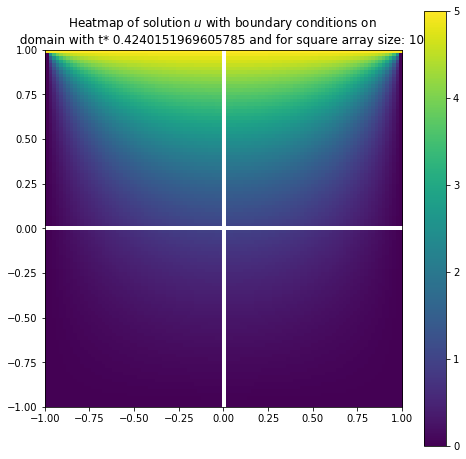

<Figure size 432x288 with 0 Axes>

In [6]:
plot_jacobi(101,10002,1)

### Implicit
<a id="finiteimplicit"></a>

In [7]:
class matrix_A_finite():
    '''Class for representing system Ax=b'''
    def __init__(self,m,c):
        '''Constructor for creating A and 
        common variables across system.'''
        
        self.m=m #+2
        self.m_orig = self.m #+2
        self.h = (1/(self.m-1))
        self.h2 = 1/((2/(self.m-1))**2)

        #define B matrix
        self.B = sp.sparse.coo_matrix((self.m, self.m), dtype=np.int8)#main diagonal of 4s #sub diagonals of -1
        self.B.setdiag(np.ones((self.m))*4*c*self.h2+np.ones((self.m)),k=0)
        self.B.setdiag(np.ones((self.m))*-1*c*self.h2,k=-1)
        self.B.setdiag(np.ones((self.m))*-1*c*self.h2,k=1)
        #define Identity matrix
        self.I = sp.sparse.coo_matrix((self.m, self.m), dtype=np.int8)
        self.I.setdiag(np.ones((self.m))*-1*c*self.h2,k=0)
        
        #define A matrix
        dummy = sp.sparse.coo_matrix((self.m, self.m), dtype=np.int8)
        dummy.setdiag(np.ones((self.m))*1,k=1)
        dummy.setdiag(np.ones((self.m))*1,k=-1)
        self.A = sp.sparse.kron(sp.sparse.identity(self.m),self.B,format="coo")+sp.sparse.kron(dummy,self.I,format="coo")
        
        
        #### Encoding A to recognise boundary conditions and out of domain.
        ##CORRECT#top boundary
        for w in np.arange((0),(self.m_orig-1+1),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
        
        ##CORRECT#right hand boundary
        for w in np.arange((1),(((self.m_orig)+1)),dtype='int'):
            self.A[self.m_orig*w-1,:] = 0
            self.A[self.m_orig*w-1,self.m_orig*w-1] = 1
        
        ##CORRECt#left hand boundary
        for w in np.arange((0),(self.m_orig-1+1),dtype='int'):
            self.A[w*self.m_orig,:] = 0
            self.A[w*self.m_orig,w*self.m_orig] = 1
            
        ##CORRECT#bottom boundary
        for w in np.arange(((self.m_orig-1)*self.m_orig),((self.m_orig**2)),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
            
            
    def output(self):
        '''Function to output matrix A in CSR format.'''
        return self.A

    
    def check_output_is_csr(self):
        '''Convenience function to check that
        the output of A is in CSS format.'''
        print(sp.sparse.isspmatrix_csr(self.A))
    

    def b_of_system(self):
        '''Function to create b part of system.'''
        
        b = np.zeros((self.m, self.m),dtype=np.float64)
                           
        for i in range(0,1):
            for j in range(self.m):
                b[i, j] = 5
                
        return b.flatten()

In [8]:
def plot_finite_implicit(iterations,M,plot):
    '''Function to compute t* and plot solution u
    for the finite method with the implicit time
    implementation.'''
    
    # Parameters
    t_max = 1
    time_steps = iterations
    dt = t_max/(1*time_steps)
    dx = 2/(M-1)
    
    A = matrix_A_finite(M,dt)
        
    solution_L = A.b_of_system()
    b = A.b_of_system()

    t=0
    n=0

    # Loop until midpoint temperature satisfied
    while solution_L[int(M*M/2)]<1:
    
        solution_L = sp.sparse.linalg.spsolve(A.output(), b)
        b = solution_L
        t+=dt
        n+=1
 
    # Plot if option enabled
    if plot == 1:
        plt.figure(figsize=(8,8))
        plt.imshow(solution_L.reshape(M,M), cmap='viridis',extent=[-1,1,-1,1]) 

        plt.colorbar(label='Value of $u$ at position')
        plt.title(
            'Heatmap of solution $u$ with boundary conditions on \n domain with t* '
            +str(t)+' and for square array size: '+str(M))
        plt.xlabel('$x$ Position')
        plt.ylabel('$y$ Position')
        plt.show()
    
    print('Accurate to',target_dif(t,1), 'decimal place')

/home/duncan/anaconda3/envs/hpc/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


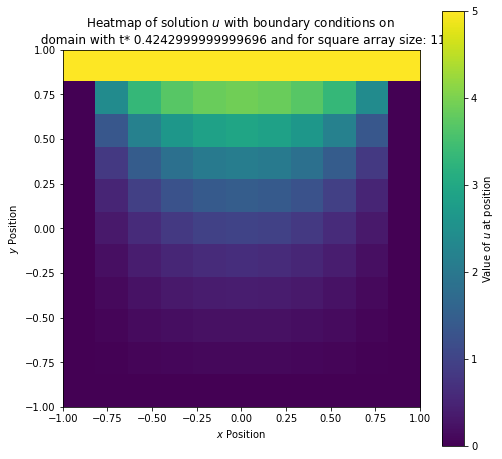

Accurate to 4.0 decimal place


In [9]:
plot_finite_implicit(1E4,11,1)

## Spectral Differentation
<a id="spectralmethods"></a>

In place of using a finite stencil discretisation to replace the operator in the problem spectral differentiation implements a Fast Fourier Transform (FFT) that represents the operator as a sum of basis functions.

While the methods are similair the key difference is that the spectral method is non zero over the entire domain whereas the finite methods is only locally non-zero. In other words this means that spectral solves the problem globally whereas finite solves locally.

Spectral methods tend to be less computationally expensive and should be more robust for more configurations of the problem. Also the error in spectral method should be better.

Here we will be using a spectral method that relies on Chebyshev polynomials as the basis functions in the Fourier expression of the operator.

### Explicit
<a id="spectralexplicit"></a>

In [10]:
def cheb(N):
    '''Function to create spectral differentiation matrix
    using chebyshev polynomials as the basis for the FFT.
    Modified from lecture notes.
    '''
    N=N-1
    if N==0: 
        D = np.array([[0.]]); x = np.array([1.])
    else:
        n = np.arange(0,N + 1)
        x = np.cos(np.pi* n / N).reshape(N + 1, 1) 
        c = (np.hstack(( [2.], np.ones(N - 1), [2.]))*(-1)**n).reshape(N + 1,1)
        X = np.tile(x,(1,N + 1))
        dX = X - X.T
        D = np.dot(c,1./c.T)/(dX + np.eye(N + 1))
        D -= np.diag( np.sum( D.T, axis=0))
    return D, x.reshape(N + 1)

In [11]:
class matrix_A_spectral():
    '''Class for representing system Ax=b with
    spectral differentiation.'''
    def __init__(self,m):
        '''Constructor for creating A and 
        common variables across system.'''
        
        self.m=m #+2
        self.m_orig = self.m #+2
        self.h = (1/(self.m-1))
        self.h2 = (1/(self.m-1))**2
        
        ##CHEB
        self.N = self.m
        self.D,self.x = cheb(self.N)
        self.I2 = np.eye(self.N)

        # Create the second derivative matrix
        self.D2 = self.D @ self.D
        # Delta operator and right-hand side
        self.A = -(np.kron(self.D2, self.I2) + np.kron(self.I2, self.D2))
        
        #### Encoding A to recognise boundary conditions and out of domain.
       
        ##CORRECT#top boundary
        for w in np.arange((0),(self.m_orig-1+1),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
        
        ##CORRECT#right hand boundary
        for w in np.arange((1),(((self.m_orig)+1)),dtype='int'):
            self.A[self.m_orig*w-1,:] = 0
            self.A[self.m_orig*w-1,self.m_orig*w-1] = 1
        
        ##CORRECt#left hand boundary
        for w in np.arange((0),(self.m_orig-1+1),dtype='int'):
            self.A[w*self.m_orig,:] = 0
            self.A[w*self.m_orig,w*self.m_orig] = 1
            
        ##CORRECT#bottom boundary
        for w in np.arange(((self.m_orig-1)*self.m_orig),((self.m_orig**2)),dtype='int'):
            self.A[w,:] = 0
            self.A[w,w] = 1
            
    def output(self):
        '''Function to output matrix A in CSR format.'''
        return self.A

    def check_output_is_csr(self):
        '''Convenience function to check that
        the output of A is in CSS format.'''
        print(sp.sparse.isspmatrix_csr(self.A))
    
    def b_of_system(self):
        '''Function to create b part of system.'''
        
        b = np.zeros((self.m, self.m),dtype=np.float64)
        
        # x0 = -5
        # y0 = -5
                
        for i in range(0,1):
            for j in range(self.m):
                b[i, j] = 5
        return b.flatten()

In [12]:
def plot_spectral_explicit(iterations,M,plot,decimal,investigate):
    '''Function to compute t* and plot solution u
    using spectral differentiation with the
    explict time implementation.
    '''
    
    #Parameters
    t_max = 1
    time_steps = iterations
    dt = t_max/(1*time_steps)
    dx = 1/(M-1)
    a = 0.5
    c = a*dt/dx**2
    
    D, x = cheb(M)
    D2 = D @ D
    I = np.eye(M)
    A = (np.kron(D2, I) + np.kron(I, D2))
    I2 = np.eye(M**2)
    
    u = np.zeros(M**2)
    u[:M] = 5
    
    midpoint = (M*M)//2
    t = 0
    iterations = 0
    
    A = I2 + dt*A

    @njit(['Tuple((float64[:],float64))(float64[:,:],float64[:],float64,float64,int8,int8)'])
    def faster(A,u,t,dt,iterations,midpoint):
        '''Numba compiled functon to accelerate
        computation.
        '''
        x=0
        # Loop until midpoint temperature satisfied
        while x < 1:
        
            u = np.dot(A,u)
            u[:M] = 5
            u[M:M*(M-1):M] = 0
            u[M+M-1:M*(M-1):M] = 0
            u[M*(M-1):] = 0

            t += dt
            iterations += 1
            x = u[midpoint]
        return u,t
    
    # Calling Numba accelerated function
    u,t = faster(A,u,t,dt,iterations,int(midpoint))
    
    # Plotting if opton enables
    if plot == 1:
        plt.figure(figsize=(8,8))
        plt.imshow(u.reshape(M,M), cmap='viridis',extent=[-1,1,-1,1]) #solution_L.reshape(M+2, M+2)

        plt.colorbar(label='Value of $u$ at position')
        plt.title(
            'Heatmap of solution $u$ with boundary conditions on \n domain with t* '
            +str(t)+' and for square array size: '+str(M))
        plt.xlabel('$x$ Position')
        plt.ylabel('$y$ Position')
        plt.show()

    ## Other output options
    if decimal == 1:    
        print('Accurate to',target_dif(t,1), 'decimal place')
    if investigate == 1:
        return M,time_steps,target_dif(t,0)

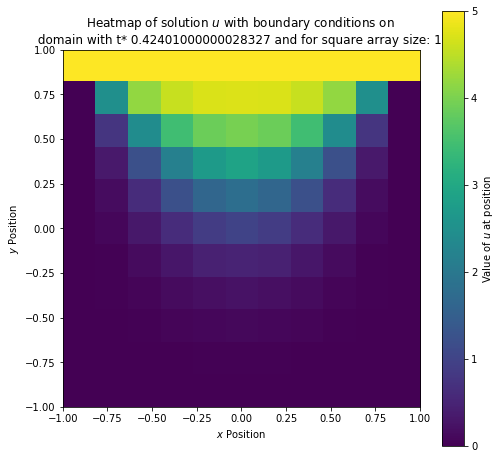

Accurate to 6.0 decimal place


In [13]:
plot_spectral_explicit(1E5,11,1,1,0)

### Implicit
<a id="spectralimplicit"></a>

In [14]:
def plot_spectral_implicit(iterations,M,plot,decimal,investigate):
    '''Function to compute t* and plot solution u
    using spectral differentiation with the
    implicit time implementation.
    '''
    
    #Parameters
    t_max = 1
    time_steps = iterations
    dt = t_max/(1*time_steps)
    dx = 1/(M-1)

    #Spectral matrix 
    D, x = cheb(M)
    D2 = D @ D
    I = np.eye(M)
    A = (np.kron(D2, I) + np.kron(I, D2))
    I2 = np.eye(M**2)
    
    A = sparse.csr_matrix(A)
    I2 = sparse.csr_matrix(I2)
    
    u = np.zeros(M**2)
    u[:M] = 5
    
    midpoint = (M*M)//2
    t = 0
    iterations = 0

    A = I2 - dt*A

    # Loop until midpoint temperature satisfied
    while u[midpoint] < 1:

        u = sp.sparse.linalg.spsolve((A), u)
        u[:M] = 5
        u[M:M*(M-1):M] = 0
        u[M+M-1:M*(M-1):M] = 0
        u[M*(M-1):] = 0

        t += dt
        iterations += 1
    
    # Plot if option enabled
    if plot == 1:
        plt.figure(figsize=(8,8))
        plt.imshow(u.reshape(M,M), cmap='viridis',extent=[-1,1,-1,1]) #solution_L.reshape(M+2, M+2)

        plt.colorbar(label='Value of $u$ at position')
        plt.title(
            'Heatmap of solution $u$ with boundary conditions on \n domain with t* '
            +str(t)+' and for square array size: '+str(M))
        plt.xlabel('$x$ Position')
        plt.ylabel('$y$ Position')
        plt.show()
    
    # Other output options
    if decimal == 1:
        print('Accurate to',target_dif(t,1), 'decimal place')

    if investigate == 1:
        return M,time_steps,target_dif(t,0)

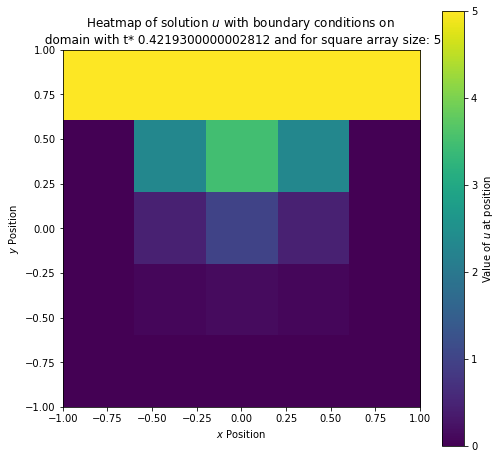

Accurate to 3.0 decimal place


In [15]:
plot_spectral_implicit(1E5,5,1,1,0)

# Investigation of parameter effects
<a id="investigation"></a>

Now that the methods for both discretisations appear to be working correctly we can begin to compare and study them over their different parameters.

For all of the methods used above there are two key parameters that define them. The size of the matrix that the space is represented by (this directly affects the spacing of points in the system) and the number of time steps the system is run in time with (this directly affects the time granularity.)

Calls for our four methods:

Finite: ```plot_jacobi(101,10002,1)```,``` plot_finite_implicit(1E5,11,1)```

Spectral: ```plot_spectral_explicit(1E5,31,1)```,```plot_spectral_implicit(1E5,5,1)```

The first thing we look at is the computaton time taken for the different methods for alike parameters, which should give some insight into proceeding with the rest of the investigation. It is worth noting though that for finite vs spectral different optimisations have been used and so it is not an 'apples to apples' comparison.

The methods are run with plotting disabled so that any plotting functions do not affect the time to compute.

In [16]:
print('Finite explicit:')
with Timer() as t:
    plot_jacobi(5,1E5,0)
print(t.interval,'s\n')

print('Finite implicit:')
with Timer() as t:
    plot_finite_implicit(1E5,5,0)
print(t.interval,'s\n')

print('Spectral explicit:')
with Timer() as t:
    plot_spectral_explicit(1E5,5,0,1,0)
print(t.interval,'s\n')

print('Spectral implicit:')
with Timer() as t:
    plot_spectral_implicit(1E5,5,0,1,0)
print(t.interval,'s\n')

Finite explicit:
Accurate to 1.0 decimal place
Courant 4e-05
0.009770870208740234 s

Finite implicit:


/home/duncan/anaconda3/envs/hpc/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Accurate to 4.0 decimal place
3.089158535003662 s

Spectral explicit:
Accurate to 3.0 decimal place
0.2651357650756836 s

Spectral implicit:
Accurate to 3.0 decimal place
2.72674560546875 s



These prelimenary results would indicate that in general the spectral methods are slower and less accurate. I do however feel that the finite implementation is not wholly correct as their behaviour in my development of the notebook has been tempermental. As such I will investgate the parameters for only for spectral (comparing the explicit and implicit implementations.)

With regards to performance the explicit method will be much faster as I have been able to use numba on part of the computation that performs a matrix product. But since with the implict method I use a solver from scipy I cannot use numba to accelerate the operation, the only performance increase I have been able to achieve is by using sparse matrices througout.

In [17]:

print('Spectral explicit:')
with Timer() as t:
    plot_spectral_explicit(1E5,5,0,1,0)
print(t.interval,'s\n')

print('Spectral implicit:')
with Timer() as t:
    plot_spectral_implicit(1E5,5,0,1,0)
print(t.interval,'s\n')

Spectral explicit:
Accurate to 3.0 decimal place
0.28487396240234375 s

Spectral implicit:
Accurate to 3.0 decimal place
2.805185556411743 s



As can be seen the time difference between the two methods is hugely different, and there is no large dfference between the two methods with regards to the order of the accuracy (as can be seen they are both accurate to the 3rd decimal place for these values).

In [18]:
from mpl_toolkits import mplot3d

In [19]:
def plot_study(option):
    '''Function to plot in 3D hardcoded data
    from a variety of runs.
    '''

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Accuracy
    zdata_1 = [0.02165138703273839, 0.0020713870327188078, 1.138703271674757e-05, 1.3870327167375684e-06,1.3870327167375684e-06, 1.3870327167375684e-06, 1.3870327167375684e-06,0.021711387033027996, 0.0021113870330301543, 1.1387033030385574e-05, 1.1387033030385574e-05, 1.1387033030385574e-05, 1.1387033030385574e-05, 1.1387033030385574e-05,0.022011387032999707, 0.0030113870329996906, 0.0010113870329996888, 0.0010113870329996888, 0.0010113870329996888, 0.20501138703299984, 0.411011387033,0.021651387032879166, 0.002071387032859584, 1.1387032857523849e-05, 1.1387032857523849e-05, 1.1387032857523849e-05, 1.1387032857523849e-05, 1.1387032857523849e-05]
    # Domain size
    xdata_1 = [3, 5, 7, 9, 11, 13, 15,3, 5, 7, 9, 11, 13, 15,3, 5, 7, 9, 11, 13, 15,3, 5, 7, 9, 11, 13, 15]
    # Time Steps
    ydata_1 = [100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0,10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0,1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0,50000.0, 50000.0, 50000.0, 50000.0, 50000.0, 50000.0, 50000.0]

    # Accuracy
    zdata_2 = [0.02167138703273841, 0.0020813870327188178, 1.138703271674757e-05, 1.138703271674757e-05, 1.138703271674757e-05, 1.138703271674757e-05, 1.138703271674757e-05,0.021811387033027985, 0.0022113870330301433, 0.00011138703303037456, 0.00011138703303037456, 0.00011138703303037456, 0.00011138703303037456, 0.00021138703303036355,0.02301138703299971, 0.0040113870329996915, 0.0010113870329996888, 0.0020113870329996897, 0.009011387032999696, 0.415011387033, 0.419011387033,0.021691387032879206, 0.002091387032859604, 3.138703285754385e-05, 3.138703285754385e-05, 3.138703285754385e-05, 3.138703285754385e-05, 3.138703285754385e-05]
    # Domain size
    xdata_2 = [3, 5, 7, 9, 11, 13, 15,3, 5, 7, 9, 11, 13, 15,3, 5, 7, 9, 11, 13, 15,3, 5, 7, 9, 11, 13, 15]
    # Time Steps
    ydata_2 = [100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0,10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0,1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0,50000.0, 50000.0, 50000.0, 50000.0, 50000.0, 50000.0, 50000.0]

    
    if option == 1:
        ax.plot_trisurf(xdata_1,ydata_1,np.log10(zdata_1))
        ax.plot_trisurf(xdata_2,ydata_2,np.log10(zdata_2))

    elif option ==0:
        ax.scatter3D(xdata_1,ydata_1,np.log10(zdata_1),label='Spectral Explicit')
        ax.scatter3D(xdata_2,ydata_2,np.log10(zdata_2),label='Spectral Implicit')
        ax.legend()


    ax.set_zlabel('Log10 Error on $T^*$')
    ax.set_xlabel('Square Domain Size')
    ax.set_ylabel('Number of Time Steps')
    

    return None

In [20]:
# Enable interactivity to better view plot
%matplotlib qt
plot_study(0)

From this plot of hard extracted data for running the solvers for different parameters there are a few interesting things to note.

First that both parameters have a clear effect on the result. Evidently increasing the size of the domain increased the accuracy of the result (though there was a limiting value for this where beyond no increase in accuracy could be noticed). From the plot it can also be noticed that an increase in the timestep (increasing the time granularity of the computation by decreasing the time iteration interval) produces a marked increase in the accuracy. These two points would imply that in general increasing the size of the domain and decreasing the time interval improve the accuracy of the computation.

The 3D plot would also indicate that the stability of a solution over the domain size paramater is lost at a lower number of time steps. This oculd however be true for all timestep values that after a large enough increase in the domain size the accuracy after converging will diverge.

Below is an alternate version of the same plot with a trangulation used for filling in between data points (same colours used for data sets).

In [21]:
plot_study(1)

It would appear that for the spectral method that going above a 30x30 domain is problematic. This may not be related to the method in of itself but a consequence of the computing optimisation done. With my initial finite explicit method I am able to achieve much higher domain sizes (101x101) without problem. My spectral explicit method is optimised with numba whereas my finite explicit is optimised with OpenCL (and its related technologies such ad SIMD and AVX2). I think there is some memory limitation that is bottlenecking my spectral method. 

From previous assignments I have seen that OpenCL based solutions may not be super fast for small scale problems compared to Numba but they tend to scale much better. It is likely that one could implement the spectral method with OpenCL and that should improve the scaling of the computation.

To make clear some of these trends below is are autogeneration methods for plotting the parameter variatons to show scaling. 

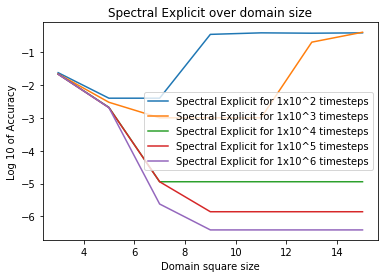

In [22]:
%matplotlib inline

#N.B. This cell is slow but does finish.
plt.figure()

def generate_expspec(j,option):
    '''Function to compute accuracies for 
    a spectral explicit plot.
    '''
    results = []
    x = []

    for i in np.arange(3,17,2):
        a,b,c = plot_spectral_explicit(1*10**j,i,0,0,1)
        results.append(c)
        x.append(i)
    
    if option ==1:
        return x
    if option ==0:
        return np.log10(results)

for j in range(2,7):
    plt.plot(
        np.arange(3,17,2),generate_expspec(j,0),
        label='Spectral Explicit for 1x10^'+str(j)+' timesteps')
plt.title('Spectral Explicit over domain size')
plt.xlabel('Domain square size')
plt.ylabel('Log 10 of Accuracy')
plt.legend()

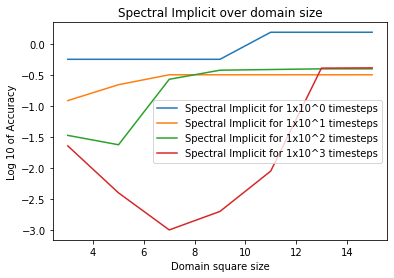

In [23]:
%matplotlib inline

#N.B. This cell is slow but does finish.
plt.figure()

def generate_impspec(j,option):
    '''Function to compute accuracies for 
    a spectral explicit plot.
    '''
    results = []
    x = []

    for i in np.arange(3,17,2):
        a,b,c = plot_spectral_implicit(1*10**j,i,0,0,1)
        results.append(c)
        x.append(i)
    
    if option ==1:
        return x
    if option ==0:
        return np.log10(results)

for j in range(0,4):
    plt.plot(
        np.arange(3,17,2),generate_impspec(j,0),
        label='Spectral Implicit for 1x10^'+str(j)+' timesteps')
plt.title('Spectral Implicit over domain size')
plt.xlabel('Domain square size')
plt.ylabel('Log 10 of Accuracy')
plt.legend()

Clear from these plots is how the increase in time step improves the accuracy of the computation for the explicit implementation. And also how a sufficient domain size is required for the accuracy to improve to a crtical value. The first plot also would appear to confirm the supposition that there is a valley on the accuracy whereby increasing the domain size further past a minimum point has no effect until it worsens the accuracy. And that the width of this valley is affected by the number of timesteps.

From the second plot we can see the behaviour is slighty reversed with implicit (whih is what we would expect). Although the range of timesteps is shifted to allow for the total runtme of the notebook to fit in the limit we can begin to see that the implicit in some instances is more accurate wth a higher time step. It is hard to determine for certain in the available scope. It is evident from the plot that the implicit accuracy sability is much lower over the variation of the parameters. Though by comparng the plots (or rexamining the 3D plots) the implicit solution is able to achieve a higher accuracy (and in a shorter computation time) than the explicit scheme for high dt and high dx.

This would imply for a small domain with not many timesteps the implicit scheme is faster and more accurate. But for larger timesteps and larger domain sizes the explicit scheme is far more scalable. This is likely due to the underlying nature of each computation in both schemes. For explicit as stated at the beginning of the notebook we are computing an equation with one unknown and many knowns whereas with implciti we are solving a system with few known and many unknowns.


Bringing this together it is suggestive that using my spectral explicit method, the best possible combinations of paramaters would be as large of a domain size as the bottleneck will allow and the highest possible number of time steps.

## Summary of highest accuracy $t^*$ peformance:

7th decimal place: ~1min
```C
plot_spectral_explicit(5E6,11,0,1,0)
```

8th decimal place: ~4mins
```C
plot_spectral_explicit(1E7,11,0,1,0)
```

9th decimal place: ~51mins
```C
plot_spectral_explicit(5E8,11,0,1,0)
```